In [1296]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [1297]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train.describe()
train['Id'] = train['Id'].astype(str)
test['Id'] = test['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [1298]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [1299]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1300]:
def IQR (df_1, col):
    for x in [col]:
        q75,q25 = np.percentile(df_1.loc[:,x],[75,25])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        df_1.loc[df_1[x] < min,x] = np.nan
        df_1.loc[df_1[x] > max,x] = np.nan

In [1301]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [1302]:
train.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [1303]:
def zamena(df, col):
    med = df[col].median()
    df[col] = df[col].fillna(med)
def zamena_1(df_4,col):
    moda = df_4[col].mode()[0]
    df_4[col] = df_4[col].fillna(moda)
zamena(train, 'Healthcare_1')
zamena(train, 'LifeSquare')
zamena(test, 'Healthcare_1')
zamena(test, 'LifeSquare')    

In [1304]:
train['Ecology_2_new'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_new'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_new'] = train['Shops_2'].replace({'A':0, 'B':1})
test['Ecology_2_new'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_new'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_new'] = test['Shops_2'].replace({'A':0, 'B':1})

In [1305]:
train.drop('Shops_2', axis=1, inplace=True)
train.drop('Ecology_2', axis=1, inplace=True)
train.drop('Ecology_3', axis=1, inplace=True)
test.drop('Shops_2', axis=1, inplace=True)
test.drop('Ecology_2', axis=1, inplace=True)
test.drop('Ecology_3', axis=1, inplace=True)

In [1306]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


In [1307]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_new,Ecology_3_new,Shops_2_new
0,11809,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,11,3097,0,900.0,0,0,305018.875000,1,1,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875,1,1,1
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750,1,1,1
3,2352,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,1,264,0,900.0,0,1,168106.000000,1,1,1
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,900.0,0,6,343995.093750,1,1,1


# 1. Распределение целевой переменной

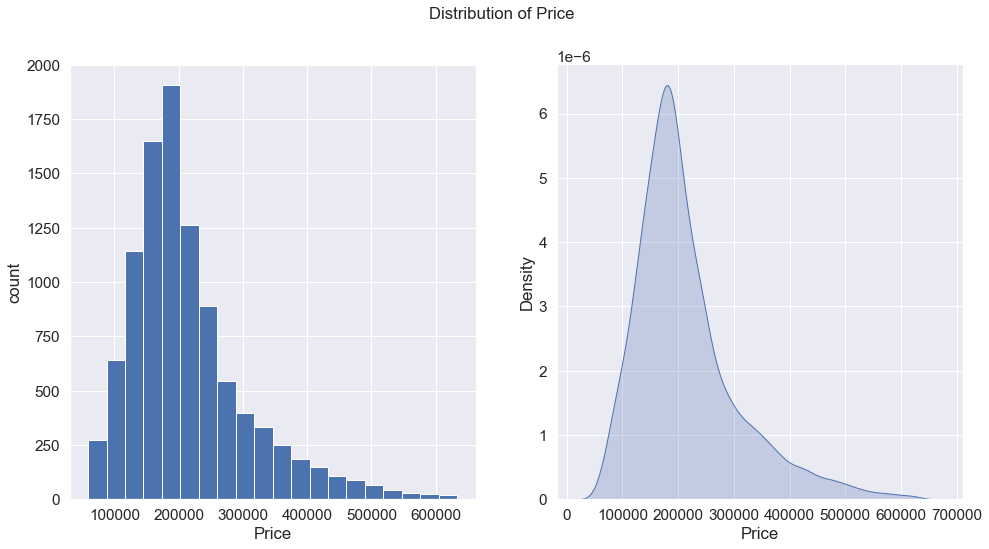

In [1308]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [1309]:
target_mean = round(train['Price'].mean(), 2)
target_median = train['Price'].median()
target_mode = train['Price'].mode()[0]

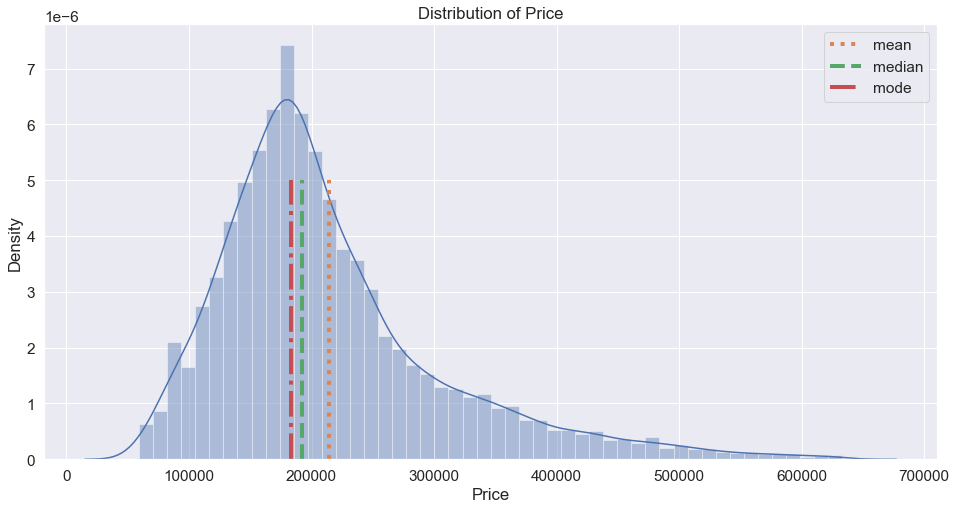

In [1310]:
plt.figure(figsize = (16, 8))

sns.distplot(train['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [1311]:
target_bins = train['Price'] // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]
target_adjusted_mode

180000.0

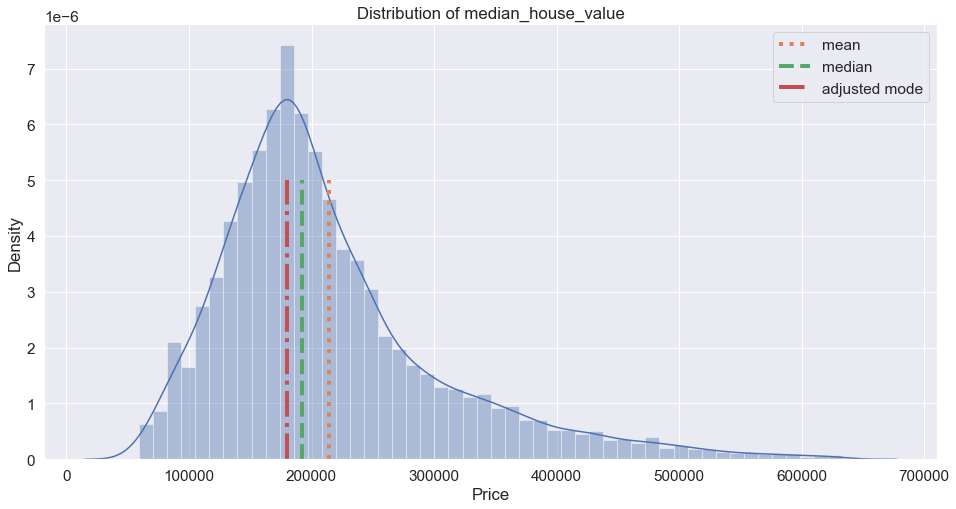

In [1312]:
plt.figure(figsize = (16, 8))

sns.distplot(train['Price'], bins=50) 

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='adjusted mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

# 2. Анализ признаков
2.1 Количественные признаки

In [1313]:
train_num_features = train.select_dtypes(include=['float64', 'float32', 'float16'])
train_num_features.drop('Price', axis=1, inplace=True)

In [1314]:
train_num_features

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027313,32.781261,10.0,10.0,0.075424,900.0
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0
3,1.0,40.409908,32.781261,1.0,22.0,0.007122,900.0
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,900.0
...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,12.0,0.300323,900.0
9996,2.0,64.307686,37.038422,9.0,0.0,0.072158,900.0
9997,1.0,29.648056,16.555363,5.0,5.0,0.460556,900.0
9998,1.0,32.330292,22.326870,5.0,9.0,0.194489,125.0


array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Healthcare_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

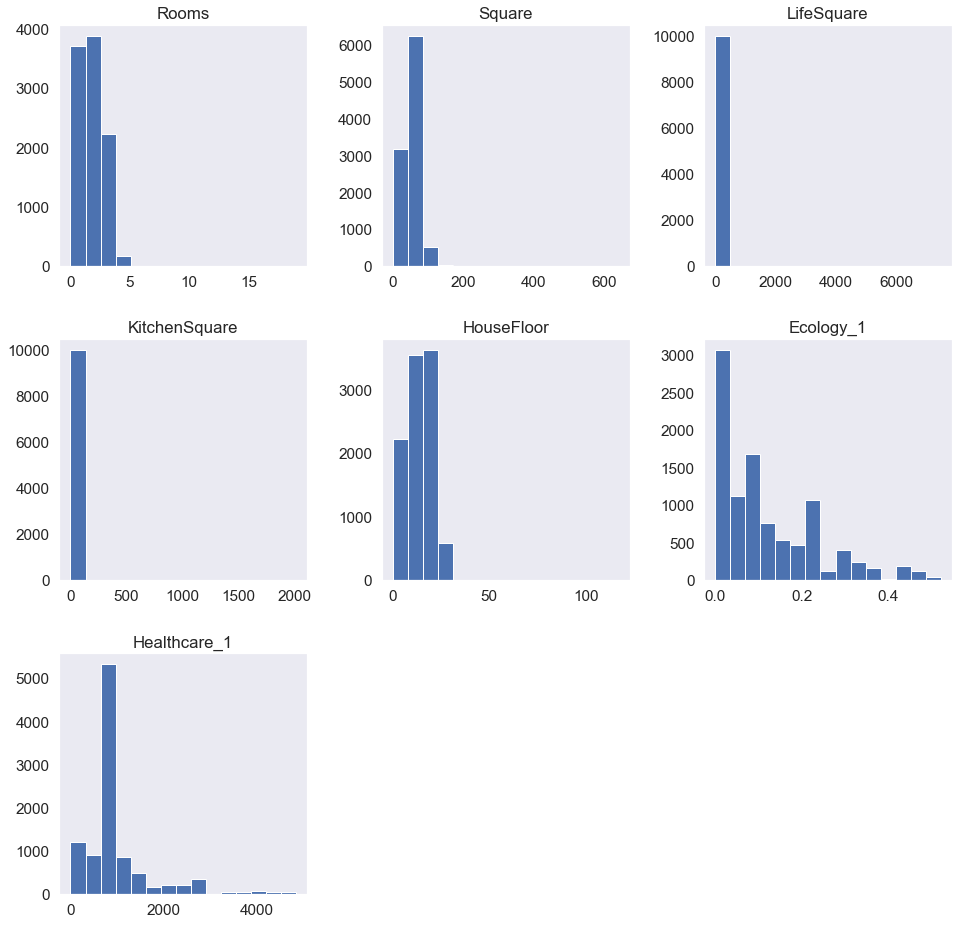

In [1315]:
train_num_features.hist(figsize=(16,16), bins=15
                        , grid=False)

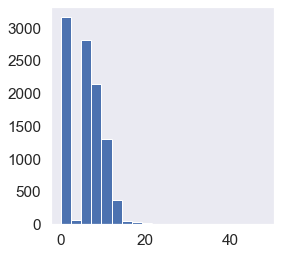

In [1316]:
train.loc[train['KitchenSquare'] < 50, 'KitchenSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);


In [1317]:
train.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = train['KitchenSquare'].median()
train.loc[train['KitchenSquare'] > 22, 'KitchenSquare'] = train['KitchenSquare'].median()
test.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = test['KitchenSquare'].median()
test.loc[train['KitchenSquare'] > 22, 'KitchenSquare'] = test['KitchenSquare'].median()

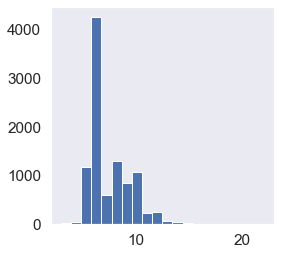

In [1318]:
train.loc[train['KitchenSquare'] < 50, 'KitchenSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);


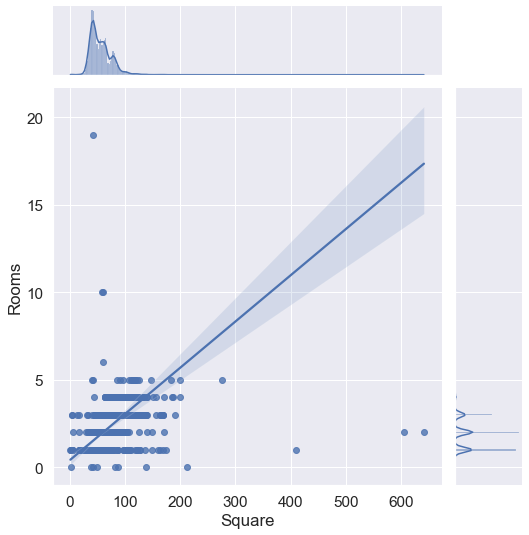

In [1319]:
grid = sns.jointplot(train['Square'], train['Rooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

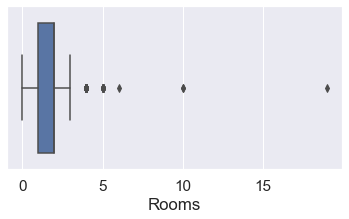

In [1320]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

In [1321]:
train.loc[train['Rooms'].isin([19,10]),'Rooms'] = int(train['Rooms'].median())
test.loc[test['Rooms'].isin([19,10]),'Rooms'] = int(test['Rooms'].median())

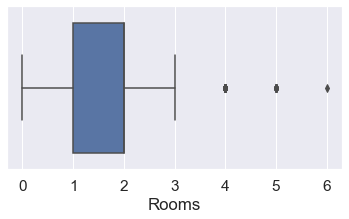

In [1322]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

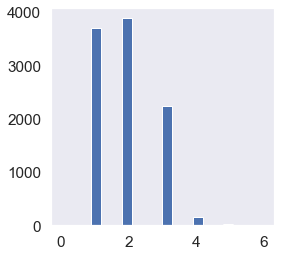

In [1323]:
train.loc[train['Rooms'] < 10, 'Rooms'].\
    hist(figsize=(4,4), bins=20, grid=False);

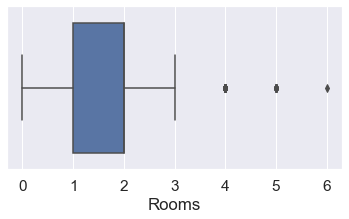

In [1324]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

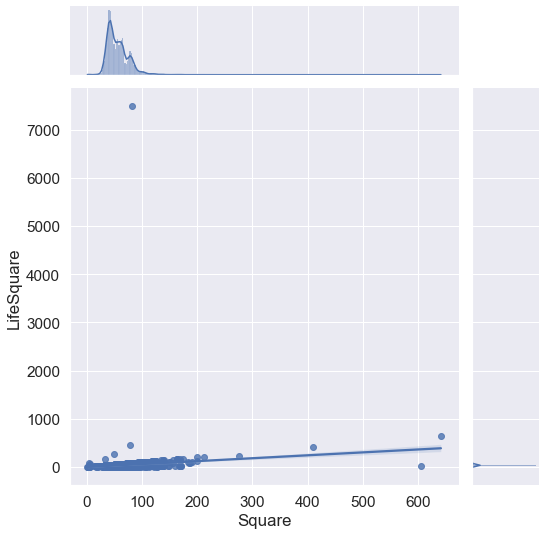

In [1325]:
grid = sns.jointplot(train['Square'], train['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

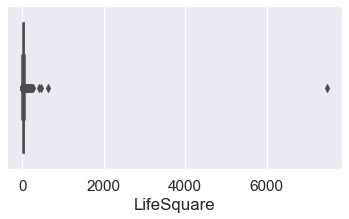

In [1326]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

In [1327]:
train.loc[train['LifeSquare'] < 18, 'LifeSquare'] = train['LifeSquare'].median()
train.loc[train['LifeSquare'] > 150, 'LifeSquare'] = train['LifeSquare'].median()
test.loc[test['LifeSquare'] < 18, 'LifeSquare'] = test['LifeSquare'].median()
test.loc[test['LifeSquare'] > 150, 'LifeSquare'] = test['LifeSquare'].median()

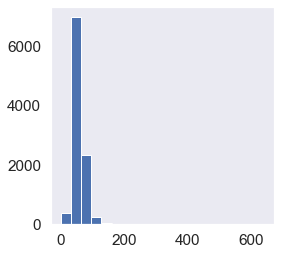

In [1328]:
train.loc[train['LifeSquare'] <200, 'Square'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [1329]:
train.loc[train['Square'] < 10, 'Square'] = train['Square'].median()
train.loc[train['Square'] > 200, 'Square'] = train['Square'].median()

In [1330]:
test.loc[train['Square'] < 10, 'Square'] = test['Square'].median()
test.loc[train['Square'] > 200, 'Square'] = test['Square'].median()

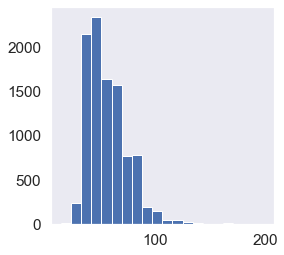

In [1331]:
train.loc[train['Square'] < 200, 'Square'].\
    hist(figsize=(4,4), bins=20, grid=False);

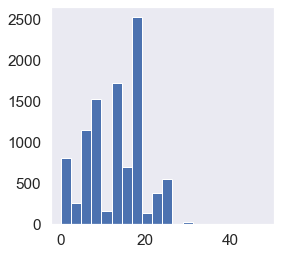

In [1332]:
train.loc[train['HouseFloor'] < 50, 'HouseFloor'].\
    hist(figsize=(4,4), bins=20, grid=False);


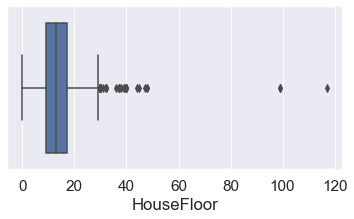

In [1333]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['HouseFloor'], whis=1.5)

plt.xlabel('HouseFloor')
plt.show()

In [1334]:
train.loc[train['HouseFloor'] > 25, 'HouseFloor'] = train['HouseFloor'].median()
test.loc[train['HouseFloor'] > 25, 'HouseFloor'] = test['HouseFloor'].median()

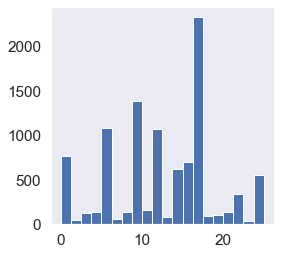

In [1335]:
train.loc[train['HouseFloor'] < 50, 'HouseFloor'].\
    hist(figsize=(4,4), bins=20, grid=False);


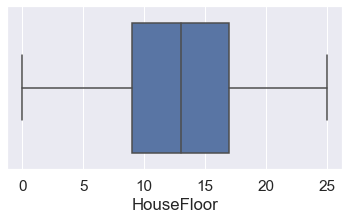

In [1336]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['HouseFloor'], whis=1.5)

plt.xlabel('HouseFloor')
plt.show()

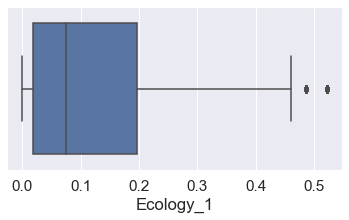

In [1337]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Ecology_1'], whis=1.5)

plt.xlabel('Ecology_1')
plt.show()

In [1338]:
train.loc[train['Ecology_1'] > 0.4, 'Ecology_1'] = train['Ecology_1'].median()
test.loc[train['Ecology_1'] > 0.4, 'Ecology_1'] = test['Ecology_1'].median()

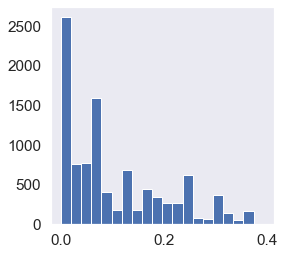

In [1339]:
train.loc[train['Ecology_1'] < 0.4, 'Ecology_1'].\
    hist(figsize=(4,4), bins=20, grid=False);


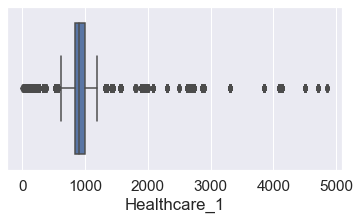

In [1340]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Healthcare_1'], whis=1.5)

plt.xlabel('Healthcare_1')
plt.show()

In [1341]:
train.loc[train['Healthcare_1'] > 1200, 'Healthcare_1'] = train['Healthcare_1'].median()
train.loc[train['Healthcare_1'] < 600, 'Healthcare_1'] = train['Healthcare_1'].median()
test.loc[test['Healthcare_1'] > 1200, 'Healthcare_1'] = test['Healthcare_1'].median()
test.loc[test['Healthcare_1'] < 600, 'Healthcare_1'] = test['Healthcare_1'].median()

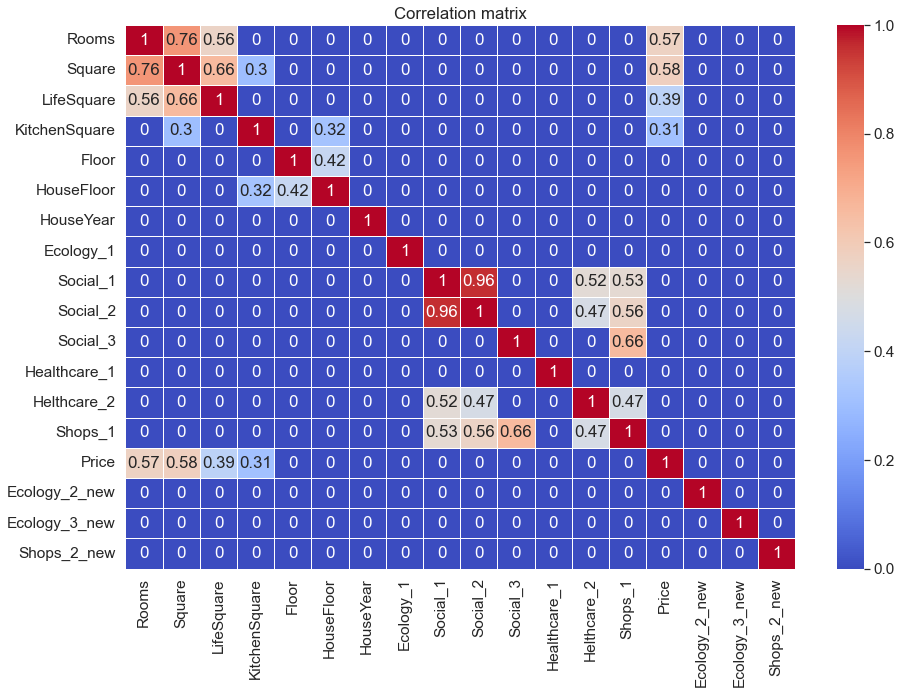

In [1342]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [1343]:
train_bin_features = train.select_dtypes(include=['int8'])

In [1344]:
train_bin_features

,Floor,Social_1,Helthcare_2,Shops_1,Ecology_2_new,Ecology_3_new,Shops_2_new
0,4,11,0,0,1,1,1
1,7,30,1,0,1,1,1
2,2,33,3,1,1,1,1
3,10,1,0,1,1,1,1
4,16,33,0,6,1,1,1
...,...,...,...,...,...,...,...
9995,3,52,1,9,1,1,1
9996,13,2,0,0,1,1,0
9997,3,20,1,5,1,1,1
9998,3,47,3,5,1,1,1


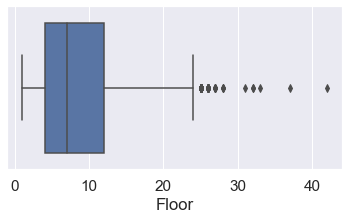

In [1345]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Floor'], whis=1.5)

plt.xlabel('Floor')
plt.show()

In [1346]:
train.loc[train['Floor'] > 22, 'Floor'] = train['Floor'].median()
test.loc[test['Floor'] > 22, 'Floor'] = test['Floor'].median()

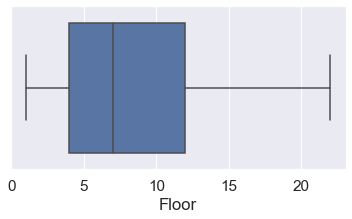

In [1347]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Floor'], whis=1.5)

plt.xlabel('Floor')
plt.show()

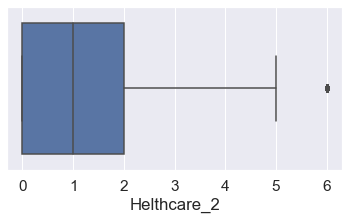

In [1348]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Helthcare_2'], whis=1.5)

plt.xlabel('Helthcare_2')
plt.show()

In [1349]:
train.loc[train['Helthcare_2'] > 5, 'Helthcare_2'] = train['Helthcare_2'].median()
test.loc[test['Helthcare_2'] > 5, 'Helthcare_2'] = test['Helthcare_2'].median()

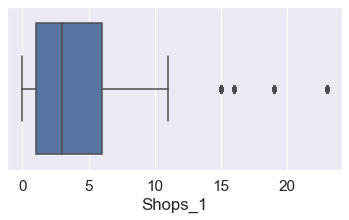

In [1350]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

In [1351]:
train.loc[train['Shops_1'] > 5, 'Shops_1'] = train['Shops_1'].median()
test.loc[train['Shops_1'] > 5, 'Shops_1'] = test['Shops_1'].median()

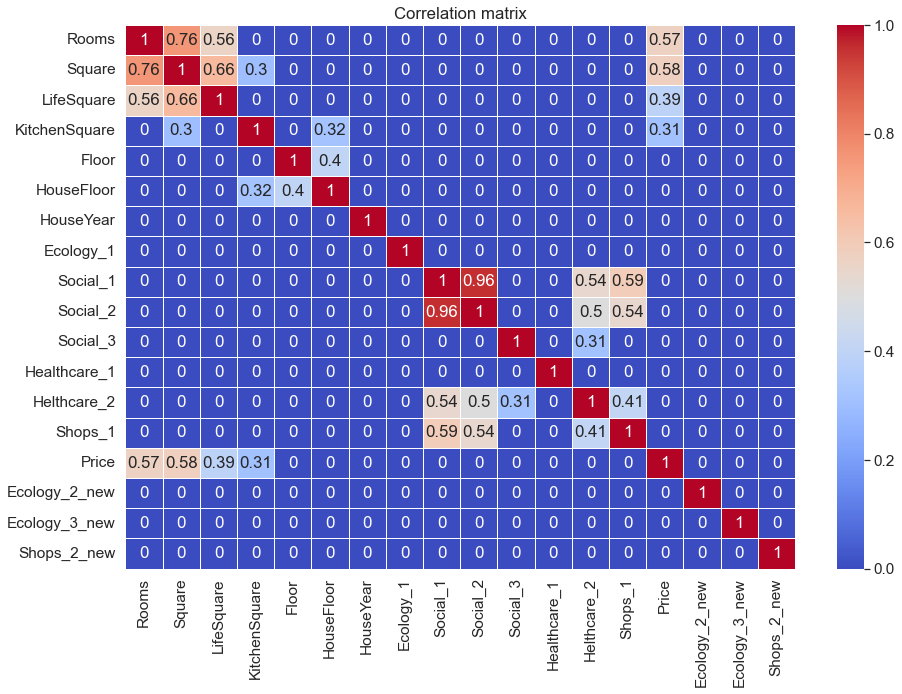

In [1352]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

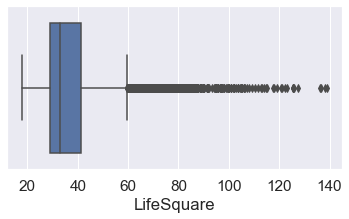

In [1353]:
plt.figure(figsize=(6, 3))

sns.boxplot(train['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

In [1354]:
def code_mean(df, col_1,col_2):
    return (df[col_1].map(df.groupby(col_1)[col_2].mean()))

In [1355]:
train['data_square_rooms'] = code_mean(train,'Square','Rooms')
train['data_square_rooms'] = code_mean(train,'Square','Rooms')
train['data_square_LifeSquare'] = code_mean(train,'Square','LifeSquare')
train['data_square_LifeSquare'] = code_mean(train,'Square','LifeSquare')
test['data_square_rooms'] = code_mean(test,'Square','Rooms')
test['data_square_rooms'] = code_mean(test,'Square','Rooms')
test['data_square_LifeSquare'] = code_mean(test,'Square','LifeSquare')
test['data_square_LifeSquare'] = code_mean(test,'Square','LifeSquare')
train['data_LifeSquare_rooms'] = code_mean(train,'LifeSquare','Rooms')
test['data_LifeSquare_rooms'] = code_mean(test,'LifeSquare','Rooms')
train['data_Shops1_Social1'] = code_mean(train,'Shops_1','Social_1')
test['data_Shops1_Social1'] = code_mean(test,'Shops_1','Social_1')
train['data_Shops1_Social2'] = code_mean(train,'Shops_1','Social_2')
test['data_Shops1_Social2'] = code_mean(test,'Shops_1','Social_2')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Id                      10000 non-null  category
 1   DistrictId              10000 non-null  category
 2   Rooms                   10000 non-null  float32 
 3   Square                  10000 non-null  float32 
 4   LifeSquare              10000 non-null  float32 
 5   KitchenSquare           10000 non-null  float32 
 6   Floor                   10000 non-null  int8    
 7   HouseFloor              10000 non-null  float32 
 8   HouseYear               10000 non-null  int32   
 9   Ecology_1               10000 non-null  float32 
 10  Social_1                10000 non-null  int8    
 11  Social_2                10000 non-null  int16   
 12  Social_3                10000 non-null  int16   
 13  Healthcare_1            10000 non-null  float32 
 14  Helthcare_2            

In [1356]:
train['DistrictId'] = train['DistrictId'].astype(str)
med_distr = train.groupby(['DistrictId','Rooms'], as_index = False).agg({'Price':'median'}).rename(columns={'Price':'Mean_Price'})
train = train.merge(med_distr, on=['DistrictId','Rooms'],how='left')

In [1357]:
train.dtypes

Id                        category
DistrictId                  object
Rooms                      float32
Square                     float32
LifeSquare                 float32
KitchenSquare              float32
Floor                         int8
HouseFloor                 float32
HouseYear                    int32
Ecology_1                  float32
Social_1                      int8
Social_2                     int16
Social_3                     int16
Healthcare_1               float32
Helthcare_2                   int8
Shops_1                       int8
Price                      float32
Ecology_2_new                 int8
Ecology_3_new                 int8
Shops_2_new                   int8
data_square_rooms          float32
data_square_LifeSquare     float32
data_LifeSquare_rooms      float32
data_Shops1_Social1        float64
data_Shops1_Social2        float64
Mean_Price                 float32
dtype: object

In [1358]:
test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Helthcare_2,Shops_1,Ecology_2_new,Ecology_3_new,Shops_2_new,data_square_rooms,data_square_LifeSquare,data_LifeSquare_rooms,data_Shops1_Social1,data_Shops1_Social2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.910000,56.449500,36.415747,5.976800,8.253800,12.601000,1984.392600,0.119874,24.933800,5406.900000,...,1.280400,4.242800,0.990400,0.970200,0.917600,1.910000,36.415747,1.910000,24.933800,5406.900000
std,0.838594,19.092787,14.281103,9.950018,4.827509,6.789213,18.573149,0.120070,17.532202,4026.614773,...,1.420767,4.777365,0.097518,0.170052,0.275001,0.838594,14.281103,0.743003,13.595326,3150.371631
min,0.000000,1.378543,18.006902,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.006902,0.000000,8.600000,2144.041739
25%,1.000000,41.906231,29.185590,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.185590,1.741680,12.797235,2461.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,32.925087,2.000000,30.549180,6028.762295
75%,2.000000,66.285129,41.756711,9.000000,11.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,...,2.000000,6.000000,1.000000,1.000000,1.000000,2.000000,41.756711,2.000000,31.399103,7016.899457
max,17.000000,223.453689,136.921090,620.000000,22.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,...,5.000000,23.000000,1.000000,1.000000,1.000000,17.000000,136.921090,17.000000,74.000000,19083.000000


In [1359]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Shops_2_new', 'Ecology_2_new','Ecology_3_new', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','Mean_Price','data_square_rooms','data_square_LifeSquare','data_Shops1_Social1','data_Shops1_Social2']
target = ['Price']
feature_names_1 = ['Id','DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Shops_2_new', 'Ecology_2_new','Ecology_3_new', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','data_square_rooms','data_square_LifeSquare','data_Shops1_Social1','data_Shops1_Social2']
feature_names_for_stand = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
  'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','Mean_Price','data_square_rooms','data_square_LifeSquare','data_Shops1_Social1','data_Shops1_Social2']
feature_names_for_stand_1 = ['Id','DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','data_square_rooms','data_square_LifeSquare','data_Shops1_Social1','data_Shops1_Social2']

In [1360]:
Xtrain = train[feature_names]
Xtest = test[feature_names_1]

In [1361]:
def features_Stand(features_,X_):
    scaler = StandardScaler()
    X_train_scaled = X_.copy()
    X_train_scaled[features_] = scaler.fit_transform(X_train_scaled[features_])
    return X_train_scaled
X2train = features_Stand(feature_names_for_stand, Xtrain)
X2test = features_Stand(feature_names_for_stand_1, Xtest)

In [1362]:
y = train['Price']
X_train, X_valid, y_train, y_valid = train_test_split((X2train), y, test_size=0.3, random_state=42)

In [1363]:
# Liner Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [1364]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()


R2:	0.7
RMSE:	50127.046
MSE:	2512720692.59


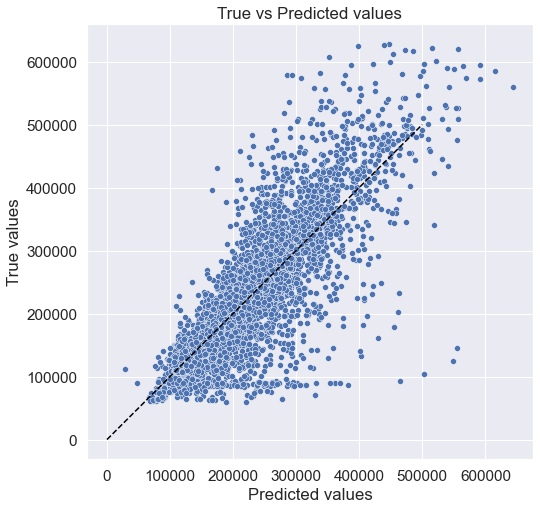

In [1365]:
y_train_preds = lr.predict(X_train)
y_train_preds
evaluate_preds(y_train, y_train_preds) 

In [1366]:
y_valid_preds = lr.predict(X_valid)
y_valid_preds
y_test_preds = lr.predict(X2test)
y_test_preds

array([189273.93314908, 239350.0494347 , 158963.65599699, ...,
       295828.08160794, 282969.94530886, 187045.62996164])

R2:	0.693
RMSE:	53169.508
MSE:	2826996574.394


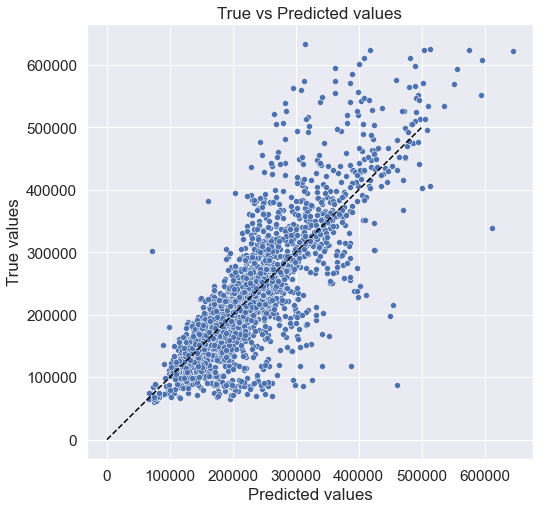

In [1367]:
evaluate_preds(y_valid, y_valid_preds)

In [1368]:
X_train, X_test, y_train, y_test = train_test_split((X2train), y, test_size=0.3, random_state=42)
def SAVE_TO_FILE(df_, modelName):
    df_.loc[:, ['Id', 'Price']].to_csv('Lipskaya_kaggle_predictions(' + modelName + ').csv', index=False)
X2test["Price"] = lr.predict(X2test)
SAVE_TO_FILE(X2test,'lr')

In [1369]:
gb_model = GradientBoostingRegressor(random_state=21)
gb_model

GradientBoostingRegressor(random_state=21)

In [1370]:
params = {'n_estimators':[50, 100, 200], 
          'max_depth':[3, 5, 7]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
X = X2train
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [1371]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [1372]:
gs.best_score_

0.76252586160293

In [1373]:
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=21,max_features=10)
gb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, max_features=10, n_estimators=200,
                          random_state=21)

R2:	0.91
RMSE:	27444.365
MSE:	753193187.489


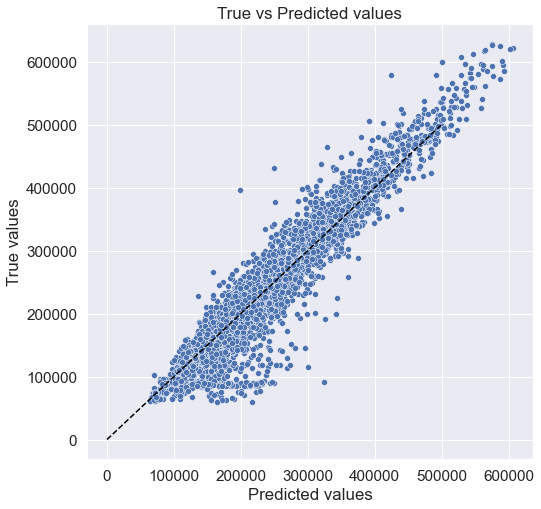

In [1374]:
y_train_preds = gb.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.749
RMSE:	48026.657
MSE:	2306559808.017


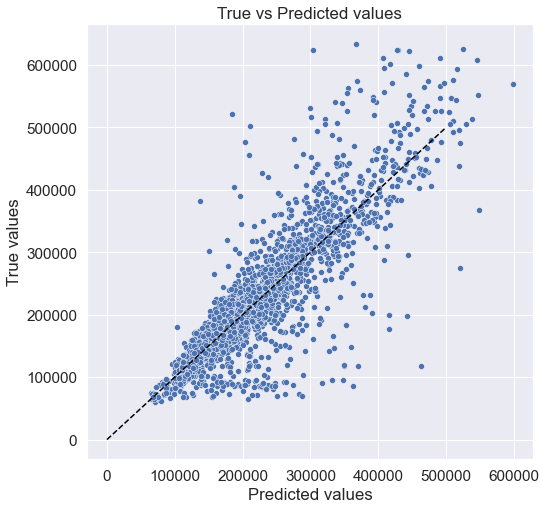

In [1375]:
y_valid_preds = gb.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

R2:	0.921
RMSE:	25716.063
MSE:	661315878.892


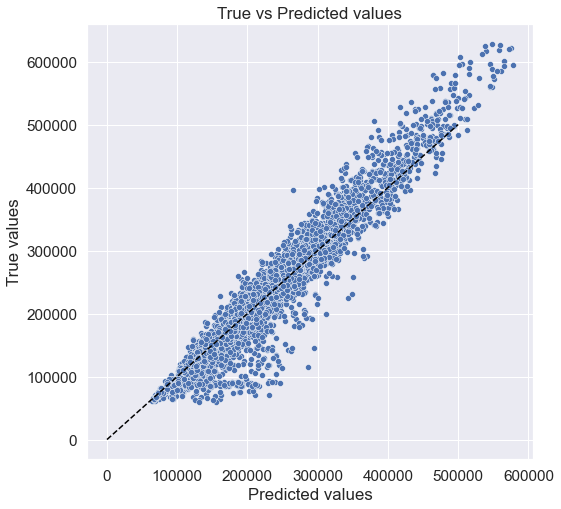

array([220826.07349539, 146286.30028861, 189382.99220736, ...,
       164154.64378483, 129635.59903713, 144297.98814166])

In [1376]:
df = X2test.drop(['Price'],axis=1)
X2test['Price'] = gb.predict(df)
SAVE_TO_FILE(X2test,'gb')
y_train_preds = rf.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_train_preds

In [1377]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=22, max_features=10)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, max_features=10, n_estimators=1000,
                      random_state=22)

R2:	0.75
RMSE:	47971.981
MSE:	2301310994.302


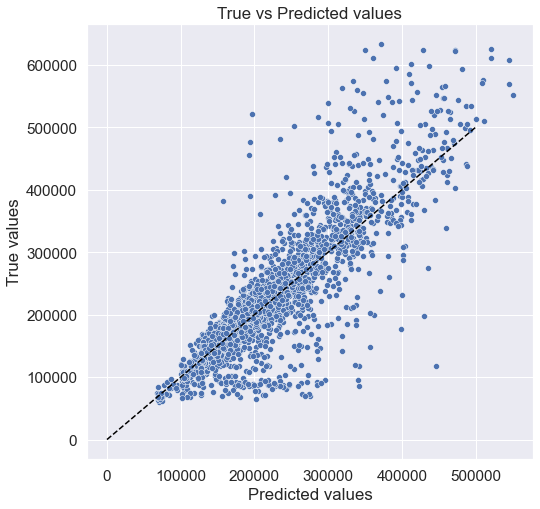

In [1378]:
y_valid_preds = rf.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [1379]:
df = X2test.drop(['Price'],axis=1)
X2test['Price'] = rf.predict(df)

In [1380]:
SAVE_TO_FILE(X2test,'gb-final5+')